# Clustering

### Imports

In [1]:
# python modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import folium
from folium.plugins import HeatMap
from folium import plugins
from folium.plugins import TimestampedGeoJson
import folium.plugins as plugins

from shapely.geometry import Point

import geopandas as gpd
from geopandas import GeoDataFrame

import plotly.express as px

import datetime
from datetime import timedelta

from scipy.spatial import ConvexHull

In [2]:
# import datasets stored as csv

bike_data = pd.read_csv("data/sf_2019_prepared.csv")
weather_data = pd.read_csv("data/weather_hourly_sf_prepared.csv")

#### Prepare Imports

In [3]:
# type cast to timestamps

bike_data[['ts_start_hour','start_time', 'end_time']] = bike_data[['ts_start_hour','start_time', 'end_time']].apply(pd.to_datetime)

weather_data['date_time'] = weather_data['date_time'].apply(pd.to_datetime)

#### Check Imports

In [4]:
bike_data.head(5)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,ts_start_hour,start_hour,start_weekday,start_month,trip_duration,start_station_latitude,start_station_longitude
0,2019-01-31 23:54:39,2019-02-01 00:14:28,34.0,146.0,Father Alfred E Boeddeker Park,30th St at San Jose Ave,5114,Subscriber,2019-01-31 23:00:00,23,3,1,1189.0,37.783988,-122.412408
1,2019-01-31 23:17:06,2019-02-01 00:09:40,29.0,70.0,O'Farrell St at Divisadero St,Central Ave at Fell St,4813,Subscriber,2019-01-31 23:00:00,23,3,1,3154.0,37.782405,-122.439446
2,2019-01-31 23:59:48,2019-02-01 00:05:12,223.0,129.0,16th St Mission BART Station 2,Harrison St at 20th St,1976,Subscriber,2019-01-31 23:00:00,23,3,1,324.0,37.764765,-122.420091
3,2019-01-31 23:59:45,2019-02-01 00:04:18,349.0,60.0,Howard St at Mary St,8th St at Ringold St,263,Subscriber,2019-01-31 23:00:00,23,3,1,273.0,37.781010,-122.405666
4,2019-01-31 23:51:55,2019-02-01 00:01:02,77.0,349.0,11th St at Natoma St,Howard St at Mary St,3035,Subscriber,2019-01-31 23:00:00,23,3,1,547.0,37.773507,-122.416040


In [5]:
weather_data.sample(5)

,date_time,max_temp,min_temp,precip
4039,2019-06-18 08:00:00,17.8,17.8,0.0
1896,2019-03-21 00:00:00,9.4,9.4,0.0
7921,2019-11-27 05:00:00,8.3,8.3,1.0
7574,2019-11-12 18:00:00,17.2,17.2,0.0
5435,2019-08-15 14:00:00,32.8,32.8,0.0


### Preparation base_df
#### Merging relavant data sets

In [6]:
# merging weather and bike data
# num of columns and rows to be reduced for specific clustering tasks (dropping columns, aggregating data if needed)

base_df = pd.merge(bike_data, weather_data, left_on=['ts_start_hour'], right_on=['date_time'])
base_df = base_df.drop(columns=['date_time'])
base_df.set_index('start_time', inplace=True)
base_df.sort_index(inplace=True)
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1960299 entries, 2019-01-01 00:08:40 to 2019-12-31 23:59:41
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   end_time                 datetime64[ns]
 1   start_station_id         float64       
 2   end_station_id           float64       
 3   start_station_name       object        
 4   end_station_name         object        
 5   bike_id                  int64         
 6   user_type                object        
 7   ts_start_hour            datetime64[ns]
 8   start_hour               int64         
 9   start_weekday            int64         
 10  start_month              int64         
 11  trip_duration            float64       
 12  start_station_latitude   float64       
 13  start_station_longitude  float64       
 14  max_temp                 float64       
 15  min_temp                 float64       
 16  precip                   float64       

#### Encoding and adding features

In [7]:
# encoding user type as numeric value

base_df.loc[base_df['user_type'] == 'Subscriber', 'user_type'] = 0
base_df.loc[base_df['user_type'] == 'Customer', 'user_type'] = 1

In [8]:
# adding binary feature "is_weekend"

# weekday 5,6 -> weekend
base_df['is_weekend'] = base_df['start_weekday'].apply(lambda x: 1 if x >= 5 else 0) 

In [9]:
# create cyclical features for periodically occurring features (hours, days)

base_df['start_hour_sin'] = np.sin(base_df['start_hour']*(2.*np.pi/24))
base_df['start_hour_cos'] = np.cos(base_df['start_hour']*(2.*np.pi/24))

base_df['start_weekday_sin'] = np.sin(base_df['start_weekday']*(2.*np.pi/7))
base_df['start_weekday_cos'] = np.cos(base_df['start_weekday']*(2.*np.pi/7))

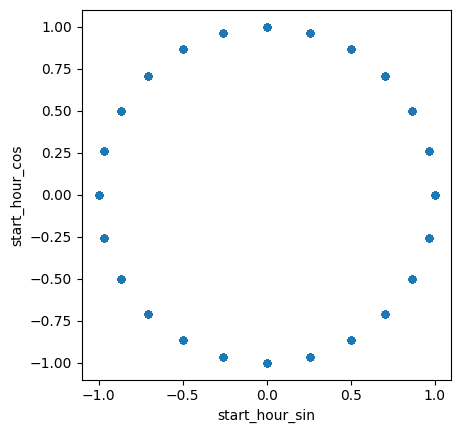

In [10]:
# Cyclical feature Hour
base_df.plot.scatter('start_hour_sin','start_hour_cos').set_aspect('equal')

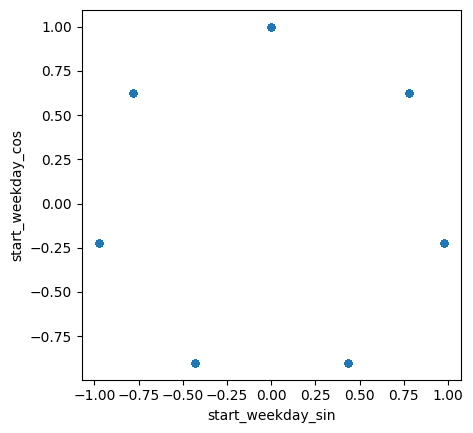

In [11]:
# Cyclical feature Weekday
base_df.plot.scatter('start_weekday_sin','start_weekday_cos').set_aspect('equal')

In [12]:
base_df.sample(5)

,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,ts_start_hour,start_hour,start_weekday,...,start_station_latitude,start_station_longitude,max_temp,min_temp,precip,is_weekend,start_hour_sin,start_hour_cos,start_weekday_sin,start_weekday_cos
start_time,,,,,,,,,,,,,,,,,,,,,
2019-09-22 11:09:40,2019-09-22 11:25:26,93.0,24.0,4th St at Mission Bay Blvd S,Spear St at Folsom St,12345,1,2019-09-22 11:00:00,11,6,...,37.770407,-122.391198,21.1,21.1,0.0,1,0.258819,-9.659258e-01,-0.781831,0.623490
2019-09-26 20:11:16,2019-09-26 20:31:51,10.0,75.0,Washington St at Kearny St,Market St at Franklin St,10729,0,2019-09-26 20:00:00,20,3,...,37.795393,-122.404770,20.0,20.0,0.0,0,-0.866025,5.000000e-01,0.433884,-0.900969
2019-06-03 06:31:44,2019-06-03 06:37:22,43.0,350.0,San Francisco Public Library (Grove St at Hyde...,8th St at Brannan St,13,1,2019-06-03 06:00:00,6,0,...,37.778768,-122.415929,13.3,13.3,0.0,0,1.000000,6.123234e-17,0.000000,1.000000
2019-09-02 16:25:32,2019-09-02 16:48:57,116.0,120.0,Mississippi St at 17th St,Mission Dolores Park,9871,1,2019-09-02 16:00:00,16,0,...,37.764802,-122.394771,20.6,20.6,0.0,0,-0.866025,-5.000000e-01,0.000000,1.000000
2019-08-30 17:45:24,2019-08-30 18:18:29,26.0,355.0,1st St at Folsom St,23rd St at Tennessee St,2202,1,2019-08-30 17:00:00,17,4,...,37.787290,-122.394380,21.1,21.1,0.0,0,-0.965926,-2.588190e-01,-0.433884,-0.900969


In [13]:
base_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1960299 entries, 2019-01-01 00:08:40 to 2019-12-31 23:59:41
Data columns (total 22 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   end_time                 1960299 non-null  datetime64[ns]
 1   start_station_id         1879975 non-null  float64       
 2   end_station_id           1884811 non-null  float64       
 3   start_station_name       1880574 non-null  object        
 4   end_station_name         1885235 non-null  object        
 5   bike_id                  1960299 non-null  int64         
 6   user_type                1960299 non-null  object        
 7   ts_start_hour            1960299 non-null  datetime64[ns]
 8   start_hour               1960299 non-null  int64         
 9   start_weekday            1960299 non-null  int64         
 10  start_month              1960299 non-null  int64         
 11  trip_duration            19602

C:\Users\leoni\AppData\Local\Temp\ipykernel_26692\1038781411.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  base_df_corr = base_df.corr()


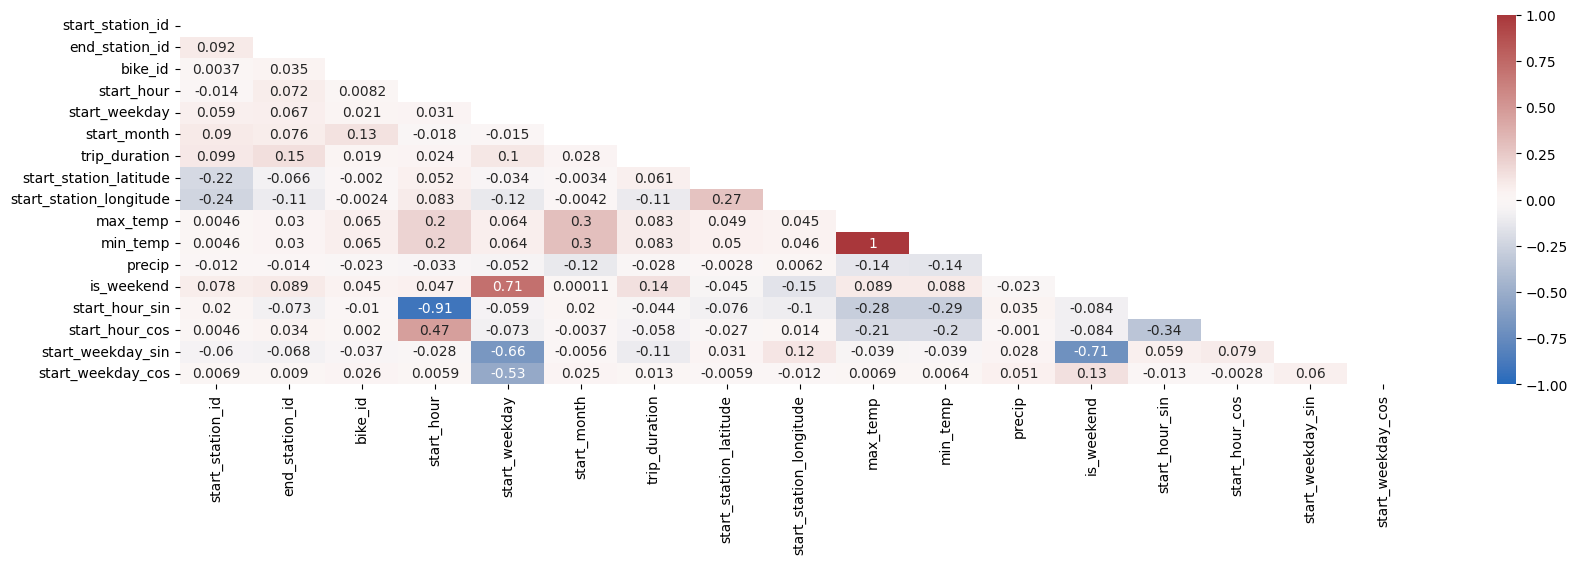

In [14]:
base_df_corr = base_df.corr()
mask = np.triu(np.ones_like(base_df_corr, dtype=bool))
f = plt.figure()
f.set_figwidth(20)
f.set_figwidth(20)
sns.heatmap(base_df_corr, annot = True, vmax= 1, vmin= -1, center=0, cmap='vlag', mask = mask)
plt.show()

#### Splitting base_df into sub dataframes for each culstering purpose

In [15]:
# create trip_df,  dataframe including data of a per trip granluarity
# for weekday and start_hour cyclical features are selected
trip_df = base_df[['start_month','start_weekday', 'start_weekday_sin', 'start_weekday_cos', 'start_hour', 'start_hour_sin', 'start_hour_cos', 'is_weekend', 'user_type', 'trip_duration']].copy()

# create weather_df, dataframe grouped by ts_start_hour and count of rides
# max_temp used as temparature feature since min and max temp are mostly the same and would influence the cluster creation 
weather_df_exploded = base_df[['ts_start_hour', 'start_month', 'start_weekday', 'start_weekday_sin', 'start_weekday_cos', 'start_hour', 'start_hour_sin', 'start_hour_cos', 'is_weekend', 'max_temp', 'precip']].copy()
weather_df_exploded.set_index('ts_start_hour', inplace=True)
weather_df_exploded = weather_df_exploded.join(pd.Series(weather_df_exploded.groupby(['ts_start_hour']).size(), name='cnt'))
weather_df = weather_df_exploded.drop_duplicates()

# create station_df
# df including station_ids

station_df = base_df[['start_hour', 'start_weekday', 'start_station_id', 'end_station_id', 'is_weekend', 'trip_duration']].copy()





# Clustering Trips

### Scaling

In [16]:
# scaling trip_df with the go-to scaling in industry

scaler = StandardScaler()
scaler.fit(trip_df)

trip_scaled = scaler.transform(trip_df)
trip_df_scaled = pd.DataFrame(trip_scaled, columns = trip_df.columns, index = trip_df.index)

trip_df_scaled.drop(columns=['start_weekday','start_hour'], inplace=True)

trip_df_scaled.sample(5)

,start_month,start_weekday_sin,start_weekday_cos,start_hour_sin,start_hour_cos,is_weekend,user_type,trip_duration
start_time,,,,,,,,
2019-01-04 16:55:34,-1.634991,-0.888657,-1.177796,-0.902082,-0.284951,-0.451158,-0.503825,-0.750682
2019-12-02 13:59:02,1.671862,-0.231949,1.412306,-0.119263,-1.234039,-0.451158,-0.503825,-0.552991
2019-01-07 20:32:12,-1.634991,-0.231949,1.412306,-0.902082,1.752042,-0.451158,-0.503825,-0.000427
2019-09-05 18:00:17,0.769993,0.424759,-1.177796,-1.074804,0.733545,-0.451158,-0.503825,0.629916
2019-04-02 21:18:24,-0.733122,0.951398,0.899305,-0.697202,2.173917,-0.451158,-0.503825,-0.792813


#### Grid search

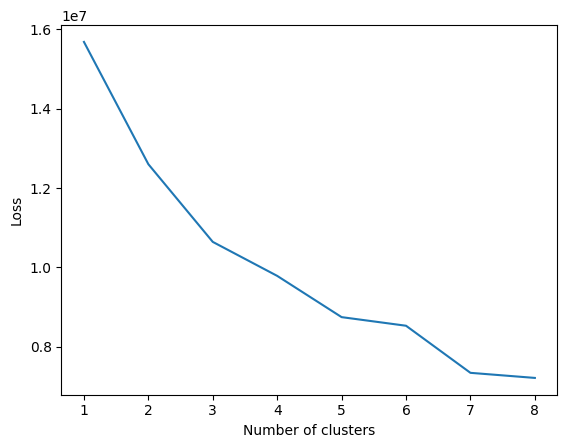

In [17]:
# Grid search for the optimum number of clusters with KMean  
# Source: Data Mining for Business Analytics by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel: Chapter 15.10

k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init="auto")
    model.fit(trip_df_scaled)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

Elbow visible at k=3 -> Optimal number of clusters is more than 3 clusters and less than 6 since the slope of the elbow chart flattening for values greater than 6. 

### Build KMeans model and fittting with trip_df_scaled
Parameters 
- `n_clusters` (number of clusters) = 3
- `random_state` (number of clusters) = 42  
- `n_init` (Number of times the k-means algorithm is run with different centroid
        seeds.) = 10 (default)

In [18]:
trip_model = KMeans(n_clusters = 3, random_state=42, n_init=10)
trip_model.fit(trip_df_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

Adding the predicted cluster as column `cluster`

In [19]:
trip_df_scaled['cluster'] = trip_model.predict(trip_df_scaled)

In [20]:
trip_df_scaled.head(5)

,start_month,start_weekday_sin,start_weekday_cos,start_hour_sin,start_hour_cos,is_weekend,user_type,trip_duration,cluster
start_time,,,,,,,,,
2019-01-01 00:08:40,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,1.984817,1.645920,1
2019-01-01 00:14:56,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,-0.503825,-0.233768,1
2019-01-01 00:15:12,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,-0.503825,1.890604,1
2019-01-01 00:15:27,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,-0.503825,1.882501,1
2019-01-01 00:16:37,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,-0.503825,-0.583779,1


Creating trip_df_complete by joining the scaled and clustered dataframe `trip_df_scaled` with the original dataframe `trip_df` in order to add the unscaled columns. It's done for visualization purposes.

In [21]:
trip_df_complete = trip_df_scaled.join(trip_df, lsuffix='_scaled', rsuffix='_unscaled')

trip_df_complete['user_type_unscaled'] = pd.to_numeric(trip_df_complete['user_type_unscaled'])

In [174]:
trip_df_complete.head(5)

,start_month_scaled,start_weekday_sin_scaled,start_weekday_cos_scaled,start_hour_sin_scaled,start_hour_cos_scaled,is_weekend_scaled,user_type_scaled,trip_duration_scaled,cluster,start_month_unscaled,start_weekday,start_weekday_sin_unscaled,start_weekday_cos_unscaled,start_hour,start_hour_sin_unscaled,start_hour_cos_unscaled,is_weekend_unscaled,user_type_unscaled,trip_duration_unscaled
start_time,,,,,,,,,,,,,,,,,,,
2019-01-01 00:08:40,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,1.984817,1.645920,2,1,1,0.781831,0.62349,0,0.0,1.0,0,1,1767.0
2019-01-01 00:14:56,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,-0.503825,-0.233768,2,1,1,0.781831,0.62349,0,0.0,1.0,0,0,607.0
2019-01-01 00:15:12,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,-0.503825,1.890604,2,1,1,0.781831,0.62349,0,0.0,1.0,0,0,1918.0
2019-01-01 00:15:27,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,-0.503825,1.882501,2,1,1,0.781831,0.62349,0,0.0,1.0,0,0,1913.0
2019-01-01 00:16:37,-1.634991,0.951398,0.899305,0.21441,2.770538,-0.451158,-0.503825,-0.583779,2,1,1,0.781831,0.62349,0,0.0,1.0,0,0,391.0


Create violin plots for each of the features that were included in clustering to interpret the different proposed clusters.  
Additionally the cluster sizes are visualized as bar plot

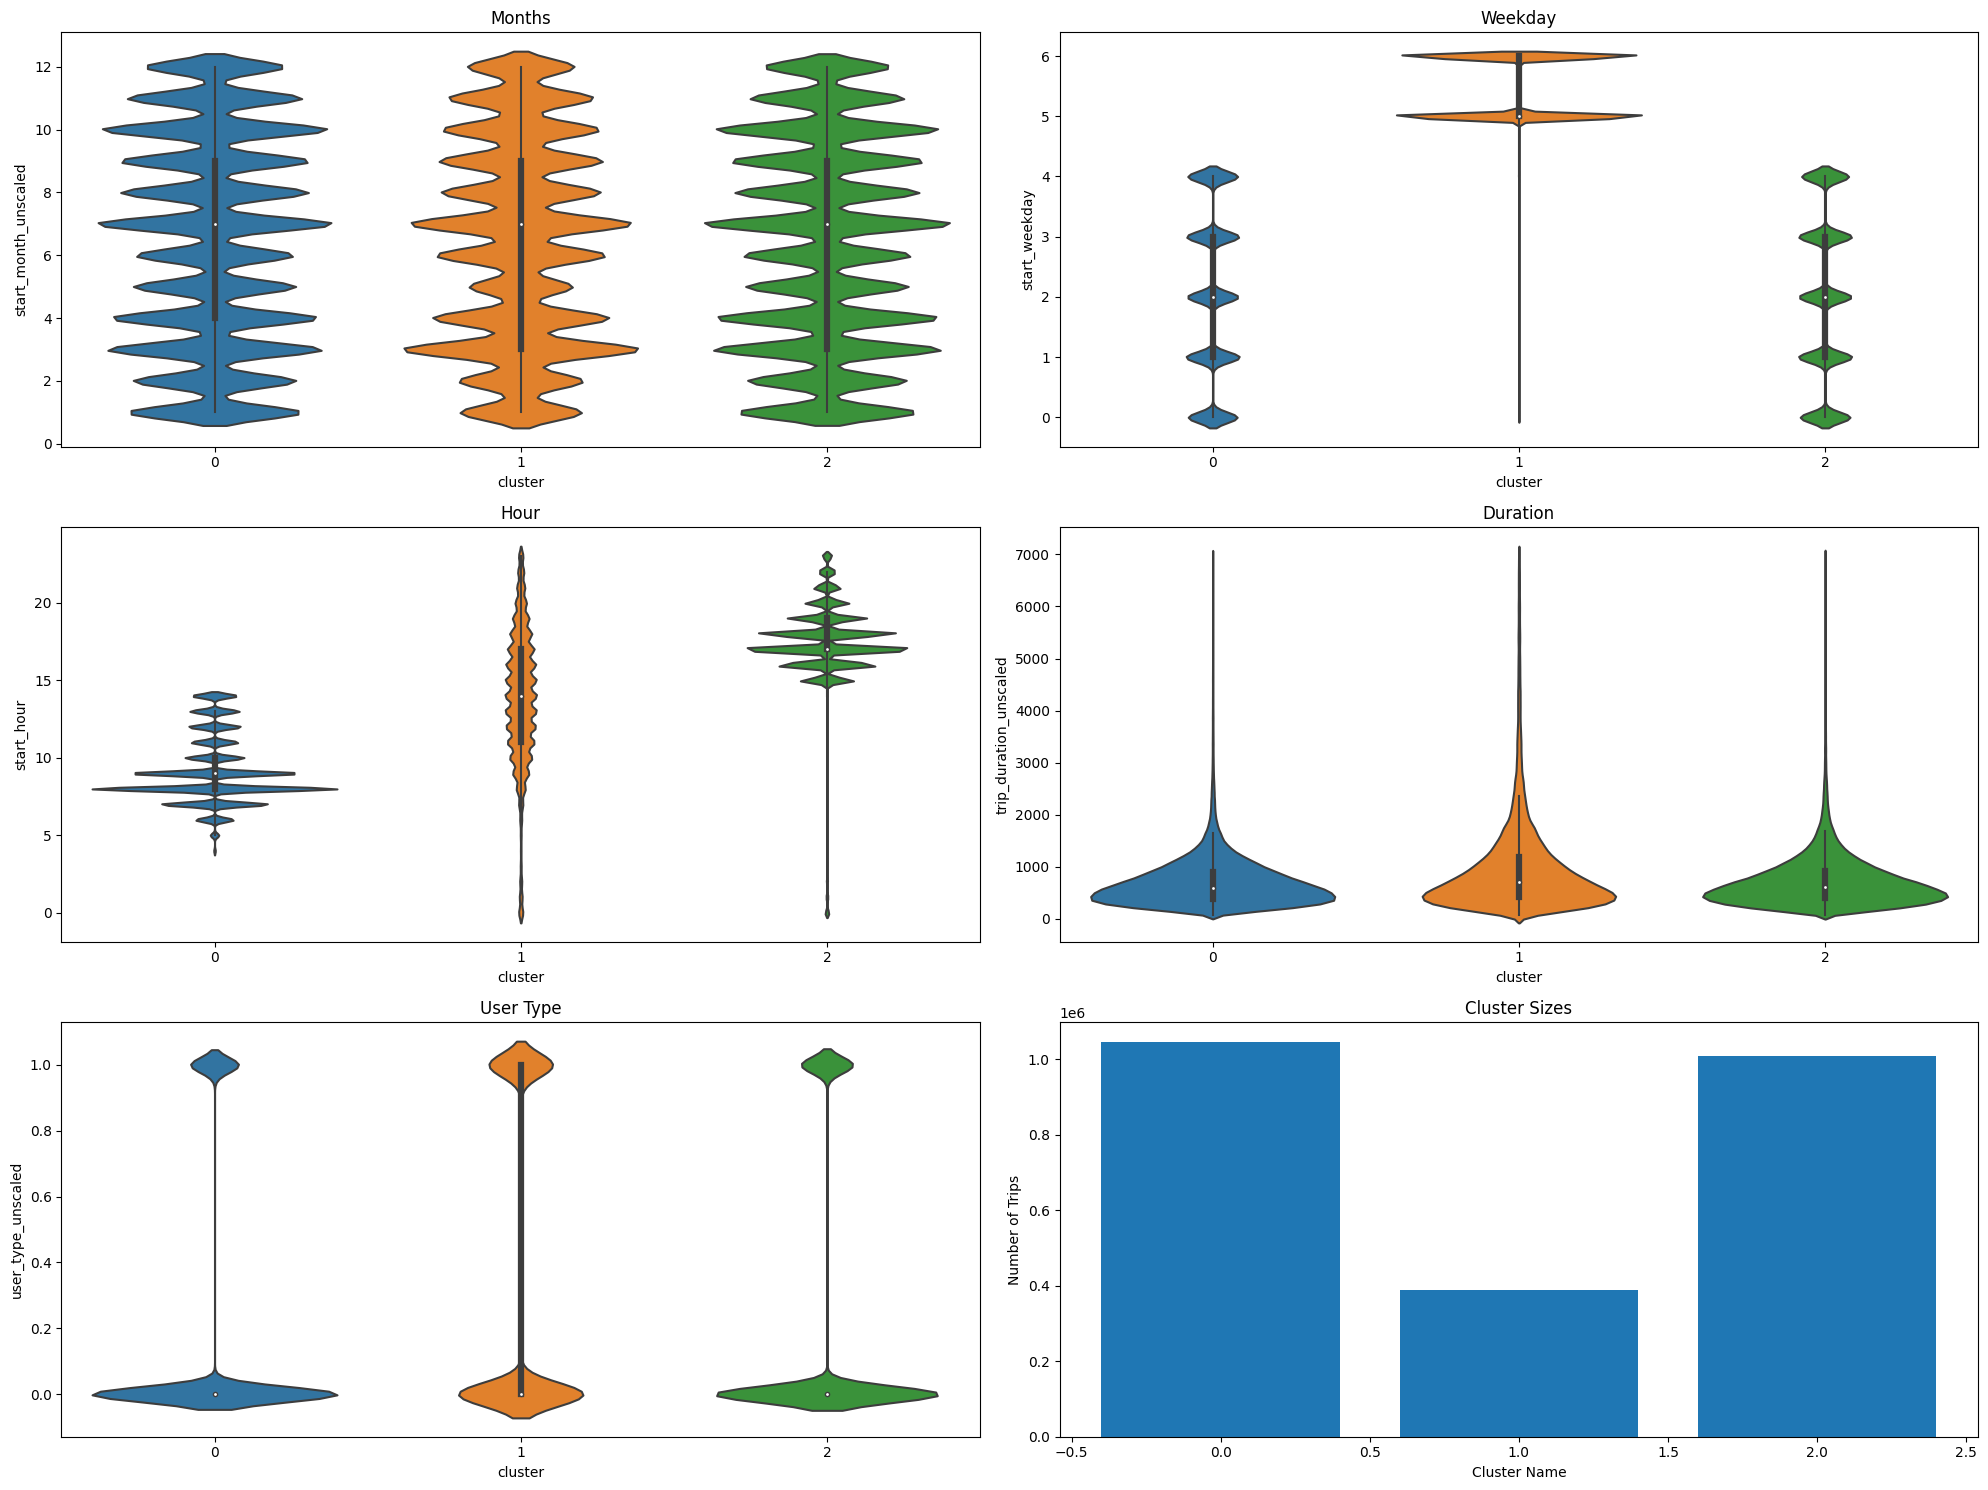

In [175]:
violin_plots, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))

sns.violinplot(ax = axes[0, 0], x=trip_df_complete['cluster'], y=trip_df_complete['start_month_unscaled'], data=trip_df_complete)
axes[0, 0].set_title('Months')

sns.violinplot(ax = axes[0, 1], x=trip_df_complete['cluster'], y=trip_df_complete['start_weekday'], data=trip_df_complete)
axes[0, 1].set_title('Weekday')

sns.violinplot(ax = axes[1, 0], x=trip_df_complete['cluster'], y=trip_df_complete['start_hour'], data=trip_df_complete)
axes[1, 0].set_title('Hour')

sns.violinplot(ax = axes[1, 1], x=trip_df_complete['cluster'], y=trip_df_complete['trip_duration_unscaled'], data=trip_df_complete)
axes[1, 1].set_title('Duration')

sns.violinplot(ax = axes[2, 0], x=trip_df_complete['cluster'], y=trip_df_complete['user_type_unscaled'], data=trip_df_complete)
axes[2, 0].set_title('User Type')

# bar plot of cluster sizes: determined  by aggregation on cluster-name
cluster_size = trip_df_complete.groupby(['cluster']).size()

axes[2, 1].bar(cluster_size.index, cluster_size)
axes[2, 1].set_xlabel('Cluster Name')
axes[2, 1].set_ylabel('Number of Trips')
axes[2, 1].set_title('Cluster Sizes')

violin_plots.tight_layout()
plt.show()

### Results of clustering

The trip clustering was based on the features `month`, ``weekday``, ``hour``, ``is_weekend``, ``user_type`` and ``trip_duration``. Method wise we used the k-means clustering approach since it guarantees convergence and it scales to large datasets. On the downside we had to choose k the number of cluster manually. Therefore we did a grid search to identify the elbow. After comparing k=3 and k=4 clusters we preferred to set k=3, because additional cluster mainly just split the user_type 'customer'
in two different day time clusters. The 3 resulting clusters all were sufficient in size and easily distinguishable leading to a high content of information per cluster.

- Cluster No. 0 - "Early Rides to work": Customers are characterized by a short trip duration compared to Cluster 1. They are taking trips in the typical
work hour pattern described in the analysis section, but only in the morning hours. The cluster size of Cluster 0 and CLuster 2 are evenly distributed.

- Cluster No. 1 - "Weekend rides": Weekend rides are distinguishable by their weekday distribution, taking trips exclusively on weekends. Users on weekends
are taking less short rides and more longer trips, assuming that these are related to leisure activities. In terms of customer type the distribution shows no large deviation to the
customer trip ratio of around 79% across the whole dataset.

- Cluster No. 2 - "Late rides from work": The most distinctive feature is the time of day as of cluster one, but including only evening hours. Their subscriber share resembles
the one of cluster 0. Related to typical working hours, with only weekdays being included in the cluster as well. 

Analyzing the clusters created by K-Means algorithm, we presumed that the monthly feature is of less distinctive character, what was confirmed in
the predictive analysis.

# Clustering weather

### Scaling

In [22]:
scaler = StandardScaler()
scaler.fit(weather_df)

weather_scaled = scaler.transform(weather_df)
weather_df_scaled = pd.DataFrame(weather_df, columns = weather_df.columns, index = weather_df.index)

weather_df_scaled.drop(columns=['start_weekday','start_hour'], inplace=True)

### K-Means GridSearch on the scaled dataframe ``weather_df_scaled``

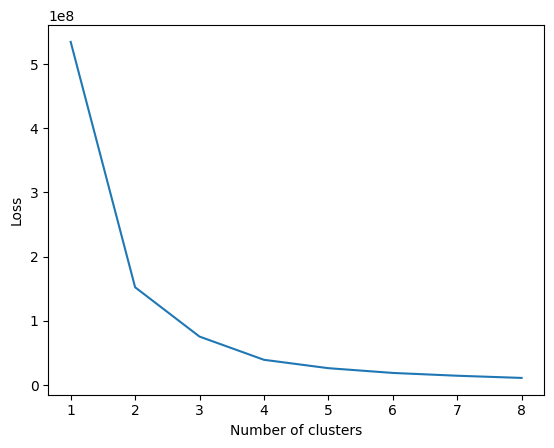

In [23]:
k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init="auto")
    model.fit(weather_df_scaled)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

Elbow visible at k=2 -> Optimal number of clusters is equal or more than 2 clusters and less than 4 since the slope of the elbow chart flattening for values greater than 4. 

### Build KMeans model and fitting with weather_df_scaled
Parameters 
- `n_clusters` (number of clusters) = 3
- `random_state` (number of clusters) = 42  
- `n_init` (Number of times the k-means algorithm is run with different centroid
        seeds.) = 10 (default)

In [24]:
weather_model = KMeans(n_clusters = 3, random_state=42, n_init=10)
weather_model.fit(weather_df_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

Adding the predicted cluster as column `cluster`

In [25]:
weather_df_scaled['cluster'] = weather_model.predict(weather_df_scaled)

In [139]:
weather_df_scaled.head()

,start_month,start_weekday_sin,start_weekday_cos,start_hour_sin,start_hour_cos,is_weekend,max_temp,precip,cnt,cluster
ts_start_hour,,,,,,,,,,
2019-01-01 00:00:00,1,0.781831,0.62349,0.000000,1.000000,0,9.4,0.0,58,0
2019-01-01 01:00:00,1,0.781831,0.62349,0.258819,0.965926,0,8.9,0.0,71,0
2019-01-01 02:00:00,1,0.781831,0.62349,0.500000,0.866025,0,8.3,0.0,35,0
2019-01-01 03:00:00,1,0.781831,0.62349,0.707107,0.707107,0,8.9,0.0,9,0
2019-01-01 04:00:00,1,0.781831,0.62349,0.866025,0.500000,0,8.3,0.0,4,0


Creating trip_df_complete by joining the scaled and clustered dataframe `weather_df_scaled` with the original dataframe `weather_df` in order to add the unscaled columns. It's done for visualization purposes.

In [140]:
weather_df_complete = weather_df_scaled.join(weather_df, lsuffix='_scaled', rsuffix='_unscaled')

In [141]:
weather_df_complete.head()

,start_month_scaled,start_weekday_sin_scaled,start_weekday_cos_scaled,start_hour_sin_scaled,start_hour_cos_scaled,is_weekend_scaled,max_temp_scaled,precip_scaled,cnt_scaled,cluster,...,start_weekday,start_weekday_sin_unscaled,start_weekday_cos_unscaled,start_hour,start_hour_sin_unscaled,start_hour_cos_unscaled,is_weekend_unscaled,max_temp_unscaled,precip_unscaled,cnt_unscaled
ts_start_hour,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,1,0.781831,0.62349,0.000000,1.000000,0,9.4,0.0,58,0,...,1,0.781831,0.62349,0,0.000000,1.000000,0,9.4,0.0,58
2019-01-01 01:00:00,1,0.781831,0.62349,0.258819,0.965926,0,8.9,0.0,71,0,...,1,0.781831,0.62349,1,0.258819,0.965926,0,8.9,0.0,71
2019-01-01 02:00:00,1,0.781831,0.62349,0.500000,0.866025,0,8.3,0.0,35,0,...,1,0.781831,0.62349,2,0.500000,0.866025,0,8.3,0.0,35
2019-01-01 03:00:00,1,0.781831,0.62349,0.707107,0.707107,0,8.9,0.0,9,0,...,1,0.781831,0.62349,3,0.707107,0.707107,0,8.9,0.0,9
2019-01-01 04:00:00,1,0.781831,0.62349,0.866025,0.500000,0,8.3,0.0,4,0,...,1,0.781831,0.62349,4,0.866025,0.500000,0,8.3,0.0,4


Create violin plots for each of the features that were included in clustering to interpret the different proposed clusters 

Additionally the number of trips per cluster are visualized as bar plot

         cnt_unscaled
cluster              
0              238722
1              811969
2              908213


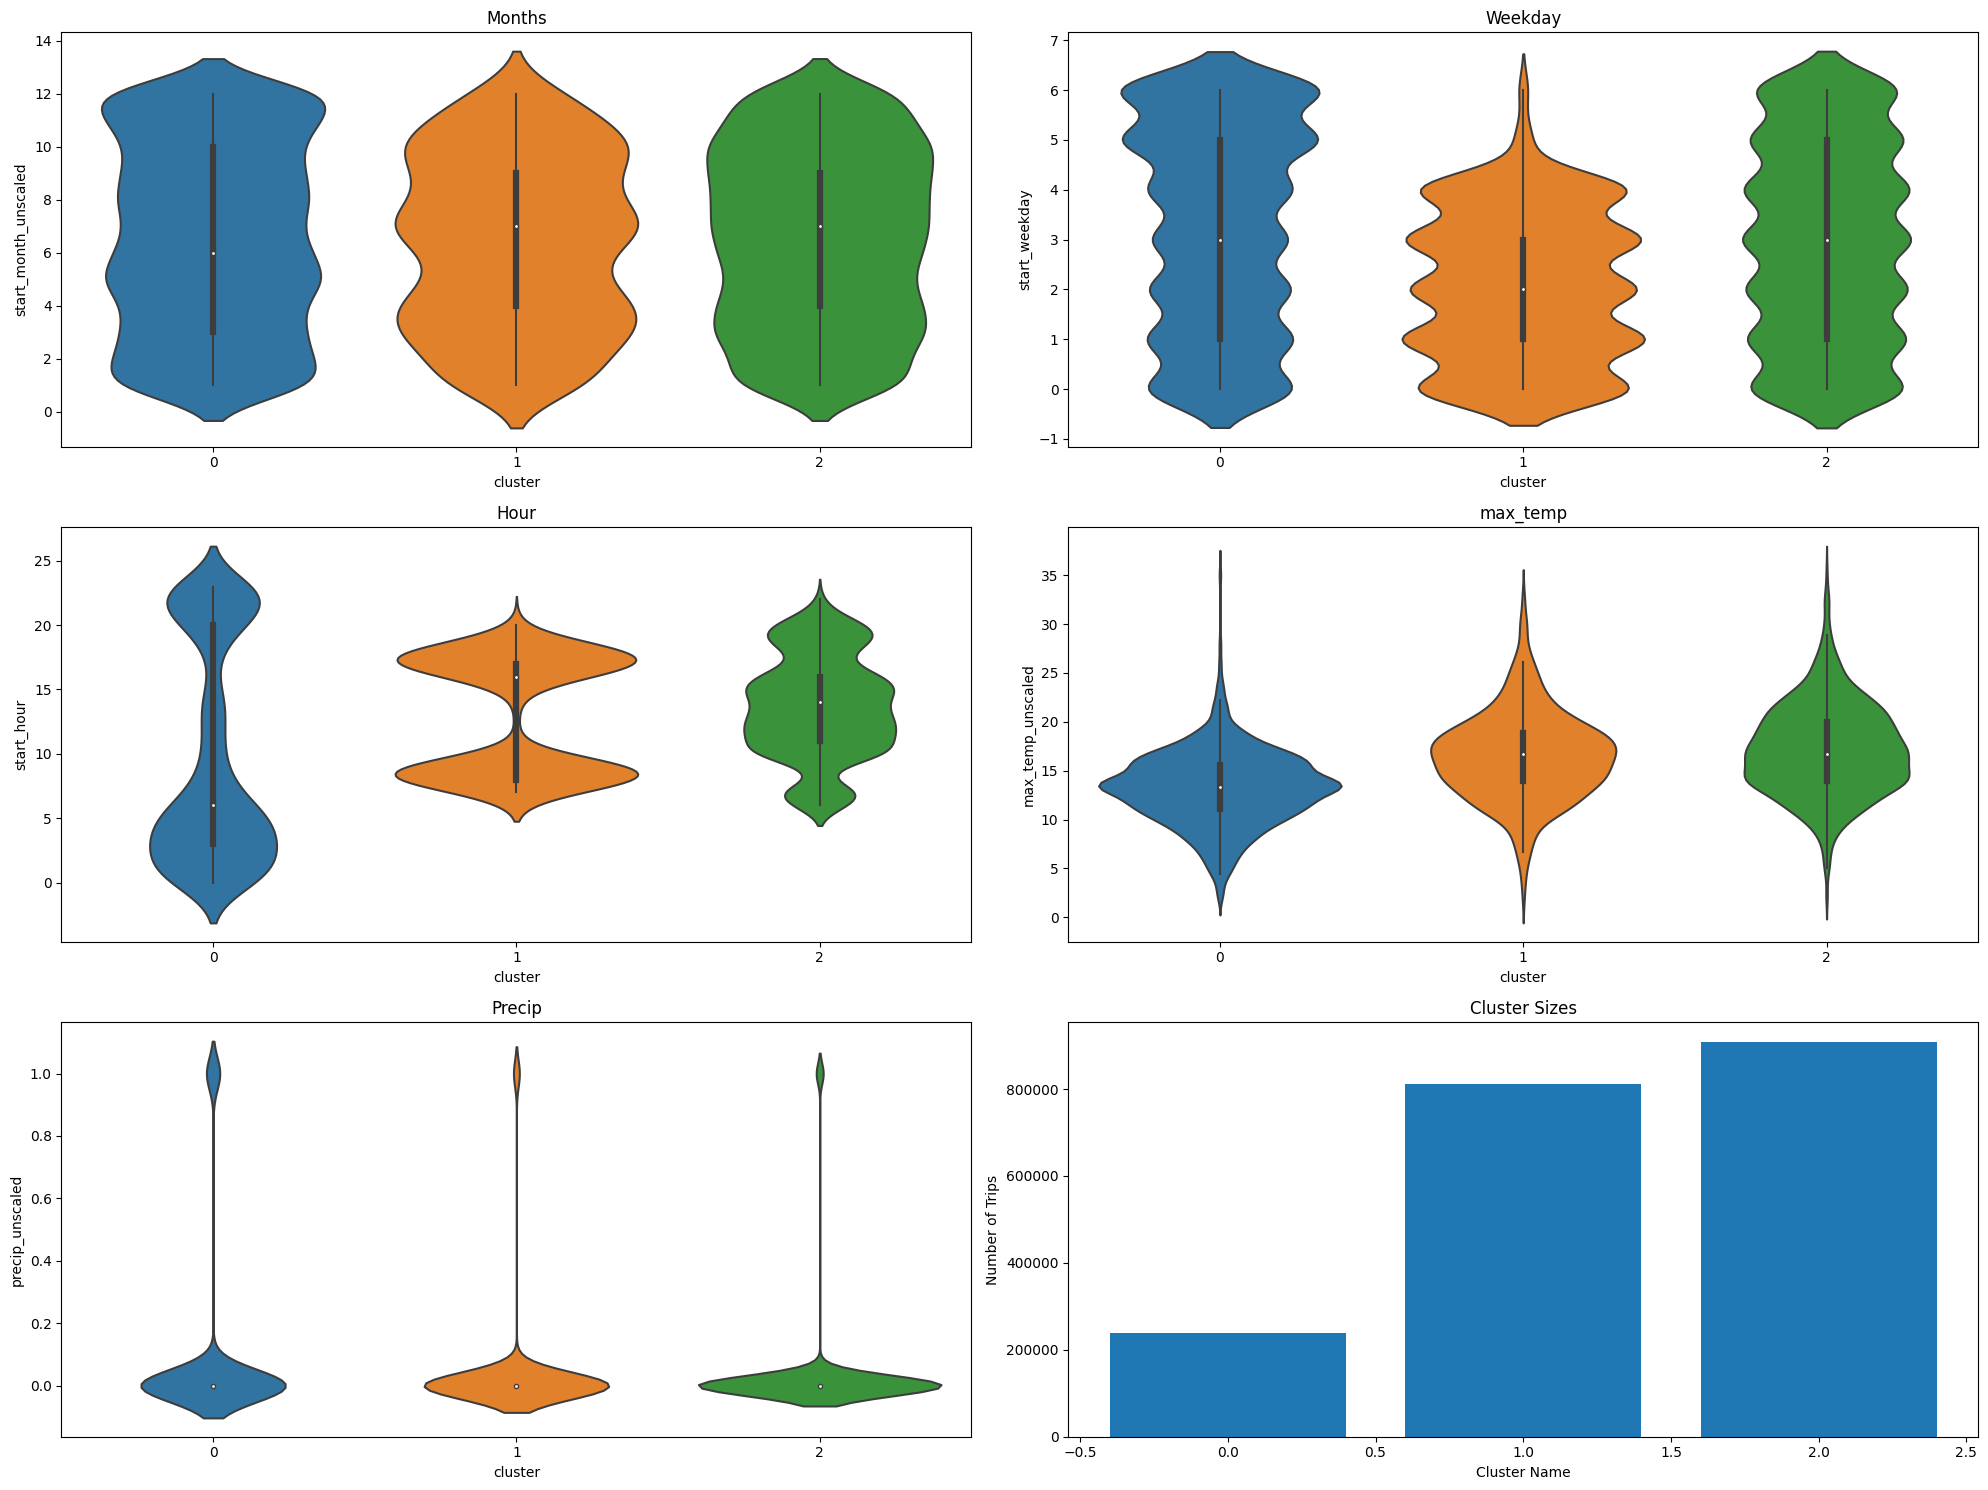

In [181]:
violin_plots, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))

sns.violinplot(ax = axes[0, 0], x=weather_df_complete['cluster'], y=weather_df_complete['start_month_unscaled'], data=weather_df_complete)
axes[0, 0].set_title('Months')

sns.violinplot(ax = axes[0, 1], x=weather_df_complete['cluster'], y=weather_df_complete['start_weekday'], data=weather_df_complete)
axes[0, 1].set_title('Weekday')

sns.violinplot(ax = axes[1, 0], x=weather_df_complete['cluster'], y=weather_df_complete['start_hour'], data=weather_df_complete)
axes[1, 0].set_title('Hour')

sns.violinplot(ax = axes[1, 1], x=weather_df_complete['cluster'], y=weather_df_complete['max_temp_unscaled'], data=weather_df_complete)
axes[1, 1].set_title('max_temp')

sns.violinplot(ax = axes[2, 0], x=weather_df_complete['cluster'], y=weather_df_complete['precip_unscaled'], data=weather_df_complete)
axes[2, 0].set_title('Precip')

# bar plot of cluster sizes: determined  by aggregation on cluster-name
cluster_size = weather_df_complete.groupby(['cluster']).agg({"cnt_unscaled" : "sum"})

axes[2, 1].bar(cluster_size.index, cluster_size["cnt_unscaled"])
axes[2, 1].set_xlabel('Cluster Name')
axes[2, 1].set_ylabel('Number of Trips')
axes[2, 1].set_title('Cluster Sizes')

violin_plots.tight_layout()
plt.show()

### Clustering results

Weather Clustering
The following features were used for K-Means Weather Data Clustering: ``precipitation``, ``max_temp``, ``start_month``, ``start_weekday`` and ``start_hour``.

- Cluster 0 "Nightriders": Cluster 0 has a greater share of rides with precipitation and a lower average temperature. Rides are distributed
around early morning hours and late evening hours where temperatures are obviously lower. 
- Cluster 1 "Workers": This cluster reconstructs the work and weekday patterns of the trip clustering. Temperature wise the cluster is evenly distributed.
- Cluster 2 "Midday rides": Cluster 2 has the highest average temperature and rare precipitation. Trips are taken around midday more often compared
to the other clusters. There is no weekday variation. 

# Clustering of the stations (without geospatial data)

In [26]:
#As a first action we seperate our dataset into weekdays and weekenddays. This is because we already saw in the visualization that the pattern is very different on the weekends
station_df_weekend = station_df[station_df['is_weekend'] == 1]
station_df_weekday = station_df[station_df['is_weekend'] == 0]


Clustering process for data containing weekdays

In [27]:
#To perform the clustering algorithmn we aggregate the trips made from each station during each hour of the day
station_count_weekday = station_df_weekday.groupby(['start_hour', 'start_station_id']).count()

#Since the groupby statement aggregates for all columns we use unstack() to receive the columns whose inner-most level consists of the pivoted index labels
station_count_weekday = station_count_weekday['start_weekday'].unstack()

#Since for some hours some stations have zero trips or no data we fill that with the number zero
station_count_weekday = station_count_weekday.fillna(0)

station_count_weekday.head()

start_station_id,3.0,4.0,5.0,6.0,8.0,9.0,10.0,11.0,12.0,13.0,...,483.0,485.0,486.0,487.0,488.0,489.0,490.0,492.0,493.0,498.0
start_hour,,,,,,,,,,,,,,,,,,,,,
0,64.0,60.0,116.0,40.0,38.0,47.0,42.0,33.0,14.0,12.0,...,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
1,38.0,17.0,54.0,8.0,0.0,10.0,12.0,4.0,2.0,6.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0
2,17.0,14.0,33.0,1.0,5.0,4.0,9.0,3.0,4.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.0,8.0,34.0,8.0,2.0,0.0,10.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,7.0,7.0,21.0,6.0,0.0,0.0,14.0,4.0,2.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#The dataframe from above shows a wide range of values. Since this can be a factor during clustering we standardize the data
scaler = StandardScaler()
scaler.fit(station_count_weekday)

station_df_scaled_weekday = scaler.transform(station_count_weekday)
station_df_scaled_weekday = pd.DataFrame(station_df_scaled_weekday, columns = station_count_weekday.columns, index = station_count_weekday.index)


station_df_scaled_weekday.head()

start_station_id,3.0,4.0,5.0,6.0,8.0,9.0,10.0,11.0,12.0,13.0,...,483.0,485.0,486.0,487.0,488.0,489.0,490.0,492.0,493.0,498.0
start_hour,,,,,,,,,,,,,,,,,,,,,
0,-0.927970,-1.091298,-0.988743,-0.948251,-0.623068,-0.685780,-1.043995,-0.763090,-0.775310,-0.770682,...,-0.800911,-0.702049,-0.813733,-0.709281,-0.479168,-0.768350,-0.733487,-0.662004,-0.996582,-0.600994
1,-0.950070,-1.392829,-1.054965,-0.981310,-0.696703,-0.756254,-1.167342,-0.820706,-0.879408,-0.783437,...,-0.842517,-0.702049,-0.813733,-0.849386,0.566289,-0.768350,-0.733487,-0.662004,-0.834426,-0.600994
2,-0.967921,-1.413866,-1.077395,-0.988542,-0.687014,-0.767683,-1.179677,-0.822693,-0.862058,-0.781311,...,-0.842517,-0.702049,-0.813733,-0.849386,-0.479168,-0.768350,-0.733487,-0.662004,-1.077660,-0.600994
3,-0.975571,-1.455940,-1.076327,-0.981310,-0.692827,-0.775302,-1.175565,-0.826667,-0.896758,-0.796191,...,-0.842517,-0.702049,-0.813733,-0.849386,-0.479168,-0.109764,-0.733487,-0.662004,-1.077660,-0.600994
4,-0.976421,-1.462952,-1.090212,-0.983376,-0.696703,-0.775302,-1.159119,-0.820706,-0.879408,-0.796191,...,-0.759305,-0.702049,-0.813733,-0.849386,-0.479168,-0.768350,-0.733487,-0.662004,-1.077660,-0.600994


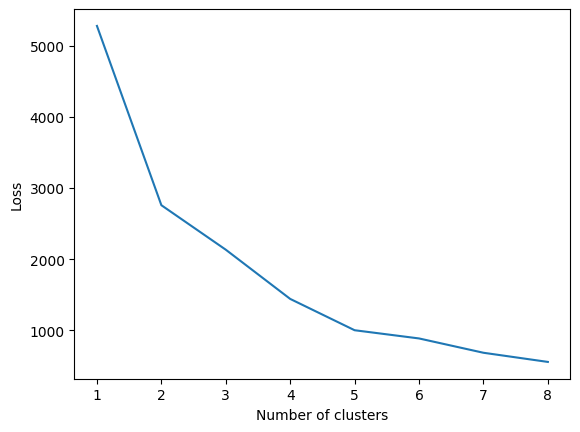

In [146]:
#Application of KMeans++ as our preferred clustering algorithm
k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init="auto")
    model.fit(station_df_scaled_weekday)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

The loss-function shows a possible k between 2 and 4. After trying out all three possibilities we opt for k = 2 since it shows data that is most plausible. 

In [30]:
#In order to be able to add our cluster to the respective start station id we again have to transpose our data
station_df_scaled_weekday_transp = station_df_scaled_weekday.transpose()

#In addition we need to transform our data into an array since otherwise the clustering cannot be fitted
station_array = station_df_scaled_weekday_transp.to_numpy()

#Kmeans fitting (with k = 2)
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(station_array)
station_df_scaled_weekday_transp['cluster'] = kmeans.predict(station_df_scaled_weekday_transp)
station_df_scaled_weekday_transp.head()

start_hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster
start_station_id,,,,,,,,,,,,,,,,,,,,,
3.0,-0.927970,-0.950070,-0.967921,-0.975571,-0.976421,-0.912670,-0.811518,-0.612614,0.590159,0.643710,...,0.200002,0.867264,3.022906,2.198390,0.823914,0.187251,-0.270907,-0.637264,-0.842118,0
4.0,-1.091298,-1.392829,-1.413866,-1.455940,-1.462952,-1.392829,0.248062,1.068507,2.113348,1.243816,...,-0.046457,0.633742,1.208755,1.398088,0.556606,0.451420,0.093790,-0.256827,-0.817816,1
5.0,-0.988743,-1.054965,-1.077395,-1.076327,-1.090212,-1.009037,-0.538008,-0.196218,1.345042,1.805390,...,0.033422,0.610193,2.346914,2.012601,0.877217,0.272675,-0.235737,-0.543348,-0.839210,0
6.0,-0.948251,-0.981310,-0.988542,-0.981310,-0.983376,-0.935854,-0.684812,0.143729,1.092109,1.012561,...,0.554901,2.081813,2.794648,1.104506,0.220178,-0.374884,-0.481293,-0.750930,-0.854239,0
8.0,-0.623068,-0.696703,-0.687014,-0.692827,-0.696703,-0.694765,-0.679263,-0.468048,-0.175447,-0.190949,...,0.442696,2.477336,3.415209,1.239112,0.022203,-0.280086,-0.287837,-0.427355,-0.621131,0


In [148]:
#To better visualize and for row deletion we transpose our data so that the clusters show up as values of the last row
station_df_clusters_weekday = station_df_scaled_weekday_transp.transpose()
station_df_clusters_weekday.tail()

start_station_id,3.0,4.0,5.0,6.0,8.0,9.0,10.0,11.0,12.0,13.0,...,483.0,485.0,486.0,487.0,488.0,489.0,490.0,492.0,493.0,498.0
start_hour,,,,,,,,,,,,,,,,,,,,,
20,0.187251,0.451420,0.272675,-0.374884,-0.280086,-0.396262,0.164805,-0.274341,-0.211448,-0.351904,...,-0.384853,-0.702049,-0.813733,-0.779334,-0.479168,0.548821,-0.733487,-0.662004,-0.104726,-0.600994
21,-0.270907,0.093790,-0.235737,-0.481293,-0.287837,-0.445785,-0.464264,-0.415403,-0.341570,-0.555979,...,-0.551276,-0.702049,-0.813733,-0.569176,-0.479168,-0.768350,-0.733487,0.159794,-0.510115,-0.600994
22,-0.637264,-0.256827,-0.543348,-0.750930,-0.427355,-0.645781,-0.579388,-0.443218,-0.567115,-0.662268,...,-0.509671,-0.524689,0.581238,-0.148861,-0.479168,-0.768350,-0.733487,-0.388071,-0.915504,0.710266
23,-0.842118,-0.817816,-0.839210,-0.854239,-0.621131,-0.701017,-0.821971,-0.604147,-0.731936,-0.721789,...,-0.676094,-0.347330,-0.813733,-0.639229,-0.479168,-0.768350,-0.733487,-0.662004,-0.834426,-0.600994
cluster,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


In [149]:
#We then define new datasets that we assign all the values from the two clusters. For completion/testing purposes the code to execute for k = 3 and k = 4 will remain

#data with cluster = 0
station_df_clusters_0 = station_df_clusters_weekday[station_df_clusters_weekday.columns[station_df_clusters_weekday.iloc[-1] == 0.000000]]
#data with cluster = 1
station_df_clusters_1 = station_df_clusters_weekday[station_df_clusters_weekday.columns[station_df_clusters_weekday.iloc[-1] == 1.000000]]


#data with cluster = 2
#station_df_clusters_2 = station_df_clusters[station_df_clusters.columns[station_df_clusters.iloc[-1] == 2.000000]]
#data with clusters = 3
#station_df_clusters_3 = station_df_clusters[station_df_clusters.columns[station_df_clusters.iloc[-1] == 3.000000]]

In [150]:
#remove cluster value since the cluster information is contained within its own dataset
station_df_clusters_0 = station_df_clusters_0.drop(['cluster'])

station_df_clusters_1 = station_df_clusters_1.drop(['cluster'])

#station_df_clusters_2 = station_df_clusters_2.drop(['cluster'])
#station_df_clusters_3 = station_df_clusters_3.drop(['cluster'])

In [151]:
#To visualize the data we aggregate the average (mean) for the start hour

station_df_clusters_0['average'] = station_df_clusters_0.mean(numeric_only=True, axis = 1)

station_df_clusters_1['average']  = station_df_clusters_1.mean(numeric_only=True, axis = 1)


#station_df_clusters_2['average'] = station_df_clusters_2.mean(numeric_only=True, axis = 1)
#station_df_clusters_3['average'] = station_df_clusters_3.mean(numeric_only=True, axis = 1)

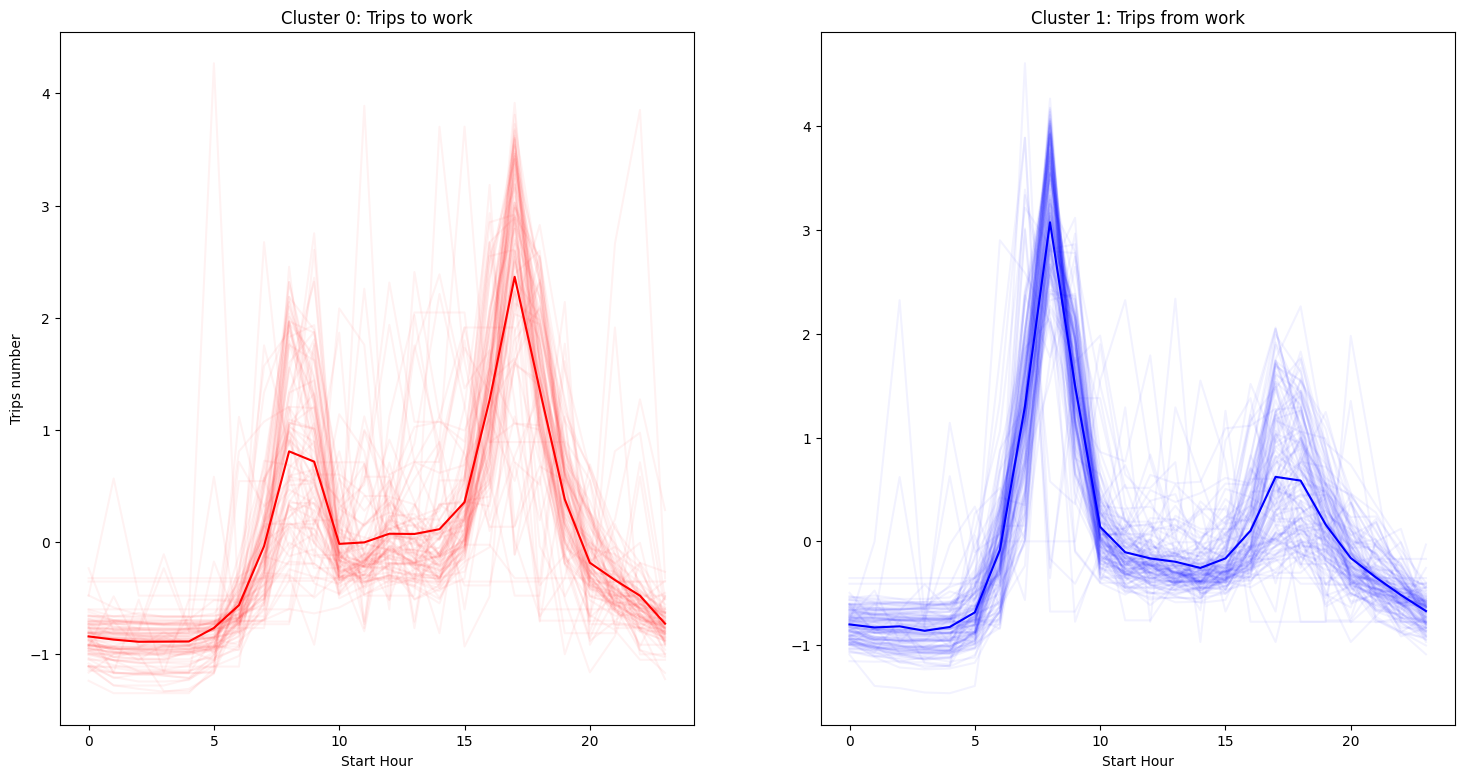

In [152]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18,9))

# plot cluster 0
station_df_clusters_0.plot(ax=ax[0],color='red', alpha=0.05)
station_df_clusters_0["average"].plot(ax=ax[0],color='red', alpha=1)
ax[0].get_legend().remove()
ax[0].set_title('Cluster 0: Trips to work')
ax[0].set_ylabel('Trips number')
ax[0].set_xlabel('Start Hour')

# plot cluster 1 
station_df_clusters_1.plot(ax=ax[1],color='blue', alpha=0.05)
station_df_clusters_1["average"].plot(ax=ax[1],color='blue', alpha=1)
ax[1].get_legend().remove()
ax[1].set_title('Cluster 1: Trips from work')
ax[1].set_xlabel('Start Hour')


plt.show()

The graph nicely visualizes two trip clusters and validates the observations made in the interactive geo-visualization: 

1. Cluster number 0 shows stations where trips are started around 7am to 8am which is the prime "going to work" time. It also shows a local maximium at around 5pm - 6pm. This could be explained with people starting trips at these stations going out in the evening. 

2. Cluster number 1 basically shows the reverse of cluster number 0. The maximum peak is at 5pm - 6pm which could be explained through people leaving the office and going back home. Since SF is densily populated and not everybody lives in the city we expect in the geovisualization that these stations are located close to the central railway station. In addition a local maximum can be seen around 7 am where we expect people living in the city to move to the central railway station for work not located in SF

Clustering process for data containing weekdays. This follows the same procedure as with the weekday data. Therefore each single line of code will not be described again.

In [153]:
station_count_weekend = station_df_weekend.groupby(['start_hour', 'start_station_id']).count()

station_count_weekend = station_count_weekend['start_weekday'].unstack()

station_count_weekend = station_count_weekend.fillna(0)

station_count_weekend.head()


start_station_id,3.0,4.0,5.0,6.0,8.0,9.0,10.0,11.0,12.0,13.0,...,482.0,483.0,485.0,486.0,487.0,488.0,489.0,490.0,492.0,493.0
start_hour,,,,,,,,,,,,,,,,,,,,,
0,82.0,32.0,83.0,34.0,39.0,19.0,35.0,17.0,7.0,23.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
1,43.0,26.0,63.0,12.0,9.0,5.0,30.0,9.0,2.0,20.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
2,20.0,18.0,29.0,14.0,8.0,3.0,21.0,5.0,1.0,10.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,11.0,9.0,19.0,8.0,1.0,6.0,6.0,2.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,8.0,7.0,16.0,4.0,5.0,1.0,10.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
scaler = StandardScaler()
scaler.fit(station_count_weekend)

station_df_scaled_weekend = scaler.transform(station_count_weekend)
station_df_scaled_weekend= pd.DataFrame(station_df_scaled_weekend, columns = station_count_weekend.columns, index = station_count_weekend.index)


station_df_scaled_weekend.head()

start_station_id,3.0,4.0,5.0,6.0,8.0,9.0,10.0,11.0,12.0,13.0,...,482.0,483.0,485.0,486.0,487.0,488.0,489.0,490.0,492.0,493.0
start_hour,,,,,,,,,,,,,,,,,,,,,
0,-0.822331,-0.928459,-0.722892,-0.854181,-0.457688,-0.531504,-0.805573,-1.019541,-0.676474,-0.549649,...,-0.807402,-0.830679,-0.603756,-0.602464,-0.753619,-0.418121,-0.517036,-0.535173,-0.650945,-0.331862
1,-1.000751,-1.049125,-0.826563,-0.950180,-0.881801,-1.084399,-0.869763,-1.171996,-0.801940,-0.646173,...,-0.957616,-0.519174,-0.603756,-0.602464,-0.753619,-0.418121,-0.517036,-0.535173,-0.650945,0.066372
2,-1.105973,-1.210014,-1.002805,-0.941453,-0.895938,-1.163385,-0.985303,-1.248223,-0.827034,-0.967919,...,-0.957616,-0.830679,-0.603756,-0.602464,-0.753619,-0.418121,-0.517036,-0.535173,0.911322,-0.730096
3,-1.147147,-1.391013,-1.054640,-0.967635,-0.994898,-1.044907,-1.177870,-1.305394,-0.852127,-1.096617,...,-0.957616,-0.830679,-0.603756,-0.602464,-1.001385,-0.418121,-0.517036,-0.535173,-0.650945,-0.331862
4,-1.160871,-1.431235,-1.070191,-0.985089,-0.938350,-1.242370,-1.126519,-1.305394,-0.852127,-1.257490,...,-0.957616,-0.830679,-0.603756,-0.602464,-1.001385,-0.418121,-0.517036,-0.535173,-0.650945,-1.128330


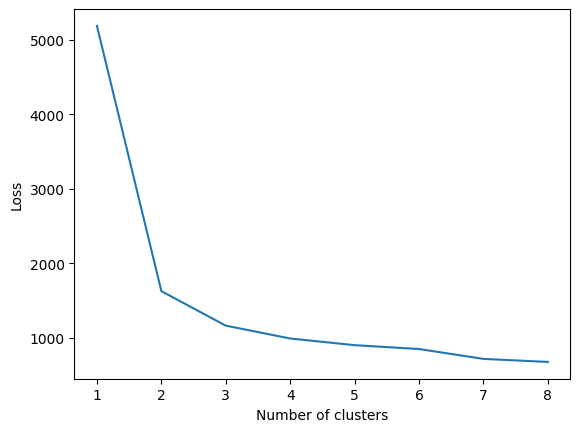

In [155]:
k_max = 8

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init="auto")
    model.fit(station_df_scaled_weekend)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

The loss-function shows a clear elbow at k = 2

In [156]:
station_df_scaled_weekend_transp = station_df_scaled_weekend.transpose()

#To apply k-means the data needs to be presented as an array
station_array = station_df_scaled_weekend_transp.to_numpy()

#Kmeans fitting
kmeans = KMeans(n_clusters=2, random_state=0).fit(station_array)
station_df_scaled_weekend_transp['cluster'] = kmeans.predict(station_df_scaled_weekend_transp)
station_df_scaled_weekend_transp.head()

/home/laurenz/.local/share/virtualenvs/aawewantatoast-jfC0HuVY/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


start_hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster
start_station_id,,,,,,,,,,,,,,,,,,,,,
3.0,-0.822331,-1.000751,-1.105973,-1.147147,-1.160871,-1.151721,-1.156296,-0.991601,-0.813182,-0.300797,...,1.391902,1.428501,1.497123,1.048787,0.531828,0.202438,-0.040030,-0.456342,-0.735409,0
4.0,-0.928459,-1.049125,-1.210014,-1.391013,-1.431235,-1.411124,-1.210014,-0.546350,0.056981,0.398869,...,1.042422,1.163088,1.303865,0.982089,0.418980,-0.264795,-0.244684,-0.506128,-0.767571,1
5.0,-0.722892,-0.826563,-1.002805,-1.054640,-1.070191,-1.090925,-1.002805,-0.966520,-0.899133,-0.463713,...,1.588980,1.677100,1.614898,1.153560,0.479696,-0.085313,-0.282289,-0.520733,-0.686607,0
6.0,-0.854181,-0.950180,-0.941453,-0.967635,-0.985089,-0.985089,-0.915271,-0.875999,-0.579272,-0.491999,...,1.641816,2.174179,1.859997,0.860726,0.467999,0.075273,-0.465817,-0.539999,-0.880362,0
8.0,-0.457688,-0.881801,-0.895938,-0.994898,-0.938350,-0.966624,-0.994898,-0.980761,-0.867664,-0.372866,...,1.931480,1.606327,1.493230,0.602594,-0.047713,-0.090124,-0.401140,-0.669745,-0.655608,0


In [157]:
station_df_clusters_weekend = station_df_scaled_weekend_transp.transpose()
station_df_clusters_weekend.tail()

start_station_id,3.0,4.0,5.0,6.0,8.0,9.0,10.0,11.0,12.0,13.0,...,482.0,483.0,485.0,486.0,487.0,488.0,489.0,490.0,492.0,493.0
start_hour,,,,,,,,,,,,,,,,,,,,,
20,0.202438,-0.264795,-0.085313,0.075273,-0.090124,-0.413026,-0.381925,-0.161983,-0.726660,0.126017,...,-0.657188,-0.519174,-0.603756,-0.602464,0.237442,-0.418121,-0.517036,-0.535173,-0.650945,0.066372
21,-0.040030,-0.244684,-0.282289,-0.465817,-0.401140,-0.255056,-0.587330,-0.581234,-0.500821,-0.646173,...,-0.506973,0.103835,-0.447948,-0.602464,-1.001385,1.588860,-0.517036,-0.535173,-0.650945,-1.128330
22,-0.456342,-0.506128,-0.520733,-0.539999,-0.669745,-0.334041,-0.754222,-0.695575,-0.726660,-0.613998,...,-0.506973,-0.519174,-0.603756,-0.602464,-1.001385,-0.418121,-0.517036,-0.535173,0.911322,0.066372
23,-0.735409,-0.767571,-0.686607,-0.880362,-0.655608,-0.176071,-0.818411,-0.981427,-0.827034,-0.967919,...,-0.807402,-0.830679,-0.603756,-0.602464,-0.505854,-0.418121,-0.517036,-0.535173,-0.650945,-0.331862
cluster,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000


In [158]:
#data with cluster = 0
station_df_clusters_0 = station_df_clusters_weekend[station_df_clusters_weekend.columns[station_df_clusters_weekend.iloc[-1] == 0.000000]]
#data with cluster = 1
station_df_clusters_1 = station_df_clusters_weekend[station_df_clusters_weekend.columns[station_df_clusters_weekend.iloc[-1] == 1.000000]]

In [159]:
#remove cluster value
station_df_clusters_0 = station_df_clusters_0.drop(['cluster'])

station_df_clusters_1 = station_df_clusters_1.drop(['cluster'])

In [160]:
#add averge for vizualization

station_df_clusters_0['average'] = station_df_clusters_0.mean(numeric_only=True, axis = 1)

station_df_clusters_1['average']  = station_df_clusters_1.mean(numeric_only=True, axis = 1)

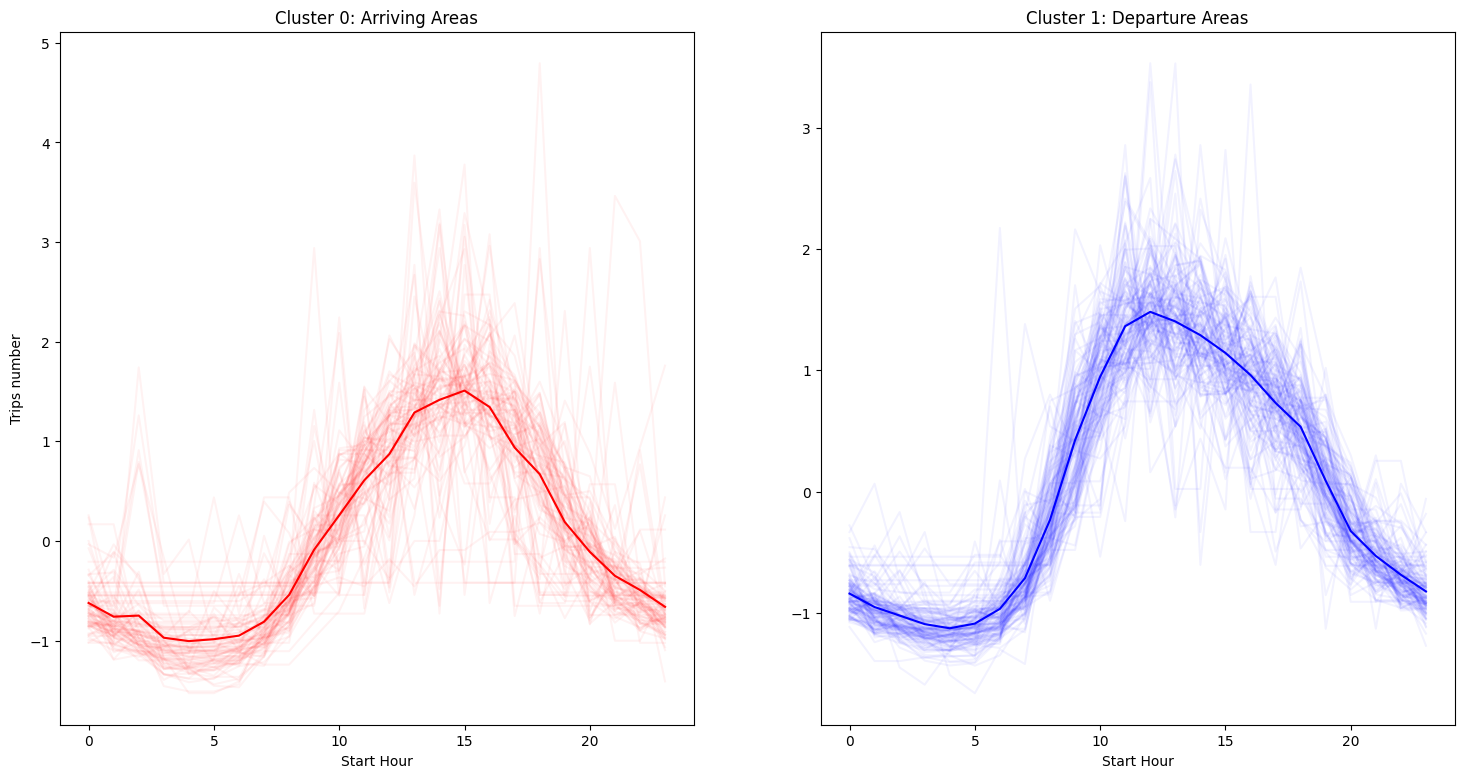

In [161]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18,9))

# plot cluster 0
station_df_clusters_0.plot(ax=ax[0],color='red', alpha=0.05)
station_df_clusters_0["average"].plot(ax=ax[0],color='red', alpha=1)
ax[0].get_legend().remove()
ax[0].set_title('Cluster 0: Arriving Areas')
ax[0].set_ylabel('Trips number')
ax[0].set_xlabel('Start Hour')

# plot cluster 1 
station_df_clusters_1.plot(ax=ax[1],color='blue', alpha=0.05)
station_df_clusters_1["average"].plot(ax=ax[1],color='blue', alpha=1)
ax[1].get_legend().remove()
ax[1].set_title('Cluster 1: Departure Areas')
ax[1].set_xlabel('Start Hour')

plt.show()

The clustering for weekends produces two very similar looking clusters. Their maximums are just a offset by a few hours

1. Cluster number 0 has its maximum at around 6pm.This could potentially include stations where people end their adventure through SF

2. Cluster number 1 has its maximum at around 12pm. This could potentially include stations where people start their adventure through SF 

# Clustering of the stations (with geospatial data)

The original following approach can be found here:
https://medium.com/codex/clustering-geographic-data-on-an-interactive-map-in-python-60a5d13d6452

In [162]:
bike_data.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,ts_start_hour,start_hour,start_weekday,start_month,trip_duration,start_station_latitude,start_station_longitude
0,2019-01-31 23:54:39,2019-02-01 00:14:28,34.0,146.0,Father Alfred E Boeddeker Park,30th St at San Jose Ave,5114,Subscriber,2019-01-31 23:00:00,23,3,1,1189.0,37.783988,-122.412408
1,2019-01-31 23:17:06,2019-02-01 00:09:40,29.0,70.0,O'Farrell St at Divisadero St,Central Ave at Fell St,4813,Subscriber,2019-01-31 23:00:00,23,3,1,3154.0,37.782405,-122.439446
2,2019-01-31 23:59:48,2019-02-01 00:05:12,223.0,129.0,16th St Mission BART Station 2,Harrison St at 20th St,1976,Subscriber,2019-01-31 23:00:00,23,3,1,324.0,37.764765,-122.420091
3,2019-01-31 23:59:45,2019-02-01 00:04:18,349.0,60.0,Howard St at Mary St,8th St at Ringold St,263,Subscriber,2019-01-31 23:00:00,23,3,1,273.0,37.781010,-122.405666
4,2019-01-31 23:51:55,2019-02-01 00:01:02,77.0,349.0,11th St at Natoma St,Howard St at Mary St,3035,Subscriber,2019-01-31 23:00:00,23,3,1,547.0,37.773507,-122.416040


In [163]:
#Because we want to cluster the stations not only based on their location but also based on their usage we start by grouping on the start_station_id
geo_clustering_station_count = bike_data.groupby(['start_station_id']).count()

# This gives us a dataframe where each column then is aggregated, which does not make much sense.
# We only keep the first column since the station ids are not our index (we can use any column here that doesn't contain null values)
geo_clustering_station_count = geo_clustering_station_count[['start_time']]

#Simple rename of our column
geo_clustering_station_count.rename(columns={'start_time': 'total_trips_started'}, inplace = True)

#From our dataset with the geospatial information we only keep our unique start stations ids with geo-information
geo_clustering_unique_stations = bike_data.drop_duplicates(subset='start_station_id')

#Select only necessary columns
geo_clustering_unique_stations = geo_clustering_unique_stations[['start_station_id', 'start_station_latitude', 'start_station_longitude']]

#Merge of geo-data with count data on start station id
geo_clustering_complete = geo_clustering_station_count.merge(geo_clustering_unique_stations, how= 'inner', left_on = 'start_station_id' , right_on = 'start_station_id')


geo_clustering_complete.head()

,start_station_id,total_trips_started,start_station_latitude,start_station_longitude
0,3.0,34020,37.786375,-122.404904
1,4.0,7051,37.785881,-122.408915
2,5.0,30341,37.783899,-122.408445
3,6.0,28503,37.804770,-122.403234
4,8.0,10342,37.799953,-122.398525


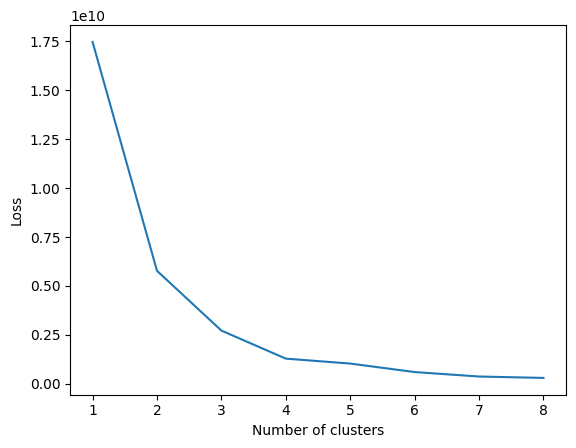

In [164]:
k_max = 8

clusters = []
losses = []
#We train KMeans only on the station count and the geo data
X = geo_clustering_complete.iloc[:, [1,2,3]].values

for k in range(k_max):
    model = KMeans(n_clusters = k + 1, n_init="auto")
    model.fit(X)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

The loss-function shows an optimum k of either 2 or three. After trying out both we conclude that we stick with 3 clusters (k = 3)

In [165]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', n_init="auto", random_state = 42)

y_kmeans = kmeans.fit_predict(X)

geo_clustering_complete['cluster'] = y_kmeans

In [166]:
#Because the folium request data as a string we typecast the start station id
geo_clustering_complete['start_station_id'] = geo_clustering_complete['start_station_id'].astype(str)

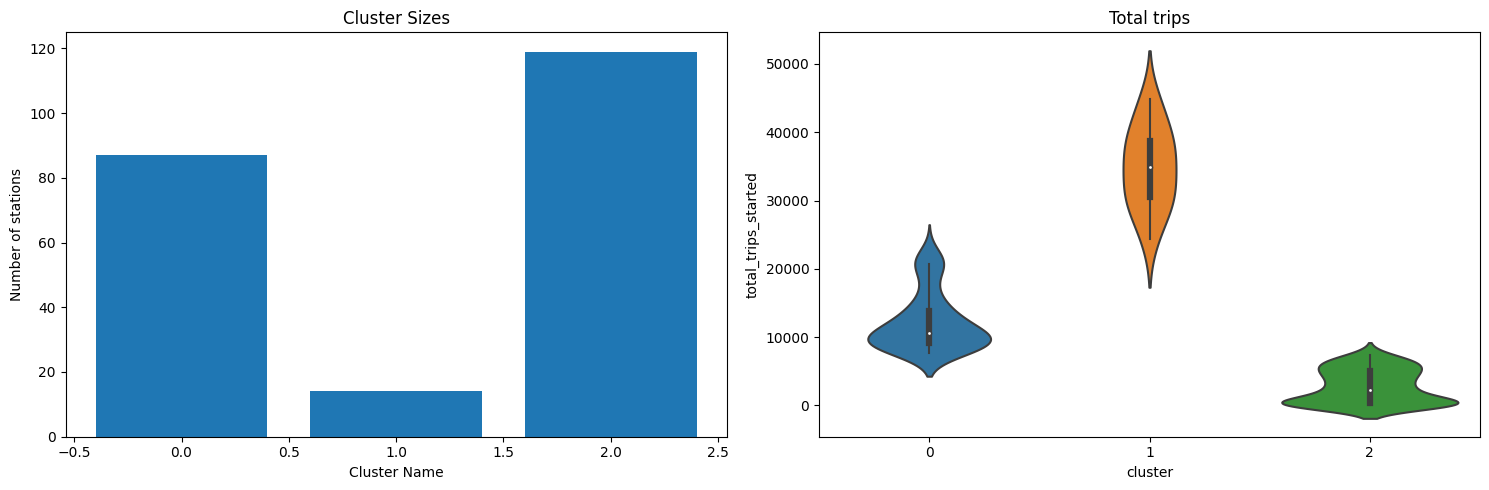

In [167]:
# Lets have a look at the clusters that are computed
violin_plots, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

# bar plot of cluster sizes: determined  by aggregation on cluster-name
cluster_size = geo_clustering_complete.groupby(['cluster']).size()

axes[0].bar(cluster_size.index, cluster_size)
axes[0].set_xlabel('Cluster Name')
axes[0].set_ylabel('Number of stations')
axes[0].set_title('Cluster Sizes')

# and show the number of total trips started
sns.violinplot(ax = axes[1], x=geo_clustering_complete['cluster'], y=geo_clustering_complete['total_trips_started'], data=geo_clustering_complete)
axes[1].set_title('Total trips')

violin_plots.tight_layout()
plt.show()

As we can see our three clusters are:
- 1. Medium-high number of stations with medium-low number of trips ("Medium performer")
- 2. Small numer of stations with high number of trips ("High performer")
- 3. High number of stations with small number of trips ("low performer")

In [168]:
geo_clustering_complete[geo_clustering_complete.cluster == 1].head()

,start_station_id,total_trips_started,start_station_latitude,start_station_longitude,cluster
0,3.0,34020,37.786375,-122.404904,1
2,5.0,30341,37.783899,-122.408445,1
3,6.0,28503,37.804770,-122.403234,1
11,15.0,38517,37.795392,-122.394203,1
12,16.0,32332,37.794130,-122.394430,1


Now we draw a map that is able to show our 3 clusters.

In [169]:
# Create the map object called m which is the base layer of the map
m = folium.Map(
    location=[
        geo_clustering_complete['start_station_latitude'].mean(),
        geo_clustering_complete['start_station_longitude'].mean()],
    tiles='CartoDB positron',
    zoom_start=13)

# create layers based on your clustering groups
layer1 = folium.FeatureGroup(name='<u><b>Medium Performer</b></u>', show=True)
m.add_child(layer1)
layer2 = folium.FeatureGroup(name='<u><b>High Performer</b></u>', show=True)
m.add_child(layer2)
layer3 = folium.FeatureGroup(name='<u><b>Low Performer</b></u>', show=True)
m.add_child(layer3)

# draw marker class for each group by adding CSS class
my_symbol_css_class = """ <style>
.fa-g1:before {
    font-family: Arial; 
    font-weight: bold;
    font-size: 12px;
    color: black;
    background-color:white;
    border-radius: 10px; 
    white-space: pre;
    content: ' g1 ';
    }
.fa-g2:before {
    font-family: Arial; 
    font-weight: bold;
    font-size: 12px;
    color: black;
    background-color:white;
    border-radius: 10px; 
    white-space: pre;
    content: ' g2 ';
    }
.fa-g3:before {
    font-family: Arial; 
    font-weight: bold;
    font-size: 12px;
    color: black;
    background-color:white;
    border-radius: 10px; 
    white-space: pre;
    content: ' g3 ';
    }
</style>
"""
# the below is just add above  CSS class to folium root map
m.get_root().html.add_child(folium.Element(my_symbol_css_class))

# then we just create marker and specific your css class in icon like below
for index, row in geo_clustering_complete.iterrows():
    if row['cluster'] == 0:
        color = 'black'
        fa_symbol = 'fa-g1'
        lay = layer1
    elif row['cluster'] == 1:
        color = 'purple'
        fa_symbol = 'fa-g2'
        lay = layer2
    elif row['cluster'] == 2:
        color = 'orange'
        fa_symbol = 'fa-g3'
        lay = layer3
    folium.Marker(
        location=[row['start_station_latitude'],
                  row['start_station_longitude']],
        title=row['start_station_id'] +
        'group:{}'.format(str(row['start_station_id'])),
        popup=row['start_station_id'] +
        'group:{}'.format(str(row['start_station_id'])),
        icon=folium.Icon(color=color, icon=fa_symbol, prefix='fa')).add_to(lay)


In [170]:
# draw cluster each group
# flat line to group path
# prepare layer and color for each group
layer_list = [layer1, layer2, layer3]
color_list = ['black', 'purple', 'orange']
for g in geo_clustering_complete['cluster'].unique():
    # this part we apply ConvexHull theory to find the boundary of each group
    # first, we have to cut the lat lon in each group
    latlon_cut = geo_clustering_complete[geo_clustering_complete['cluster']
                                         == g].iloc[:, 1:3]
    # second, scipy already provides  the great function for ConvexHull
    # we just throw our dataframe with lat lon in this function
    hull = ConvexHull(latlon_cut.values)
    
    # and with magic, we can have new lat lon boundary of each group
    Lat = latlon_cut.values[hull.vertices, 0]
    Long = latlon_cut.values[hull.vertices, 1]
    
    # the we create dataframe boundary and convert it to list of lat lon
    # for plotting polygon in folium
    cluster = pd.DataFrame({'lat': Lat, 'lon': Long})
    area = list(zip(cluster['lat'], cluster['lon']))
    
    # plot polygon
    list_index = g-1  # minus 1 to get the same index
    lay_cluster = layer_list[list_index]
    folium.Polygon(locations=area,
                   color=color_list[list_index],
                   weight=2,
                   fill=True,
                   fill_opacity=0.1,
                   opacity=0.8).add_to(lay_cluster)

# to let the map have selectd layer1 layer2 you created
folium.LayerControl(collapsed=False, position='bottomright').add_to(m)
m
